# Monte-Carlo Policy Gradient Algorithm: REINFORCE

### Short corridor with switched actions

In [13]:
import gym

class SCSA(gym.Env):
    def __init__(self):
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Discrete(4)
        self.state = 0
    
    def step(self, action):
        if self.state == 0:
            if action == 0:
                self.state = 0
            elif action == 1:
                self.state = 1
        elif self.state == 1:
            if action == 0:
                self.state = 2
            elif action == 1:
                self.state = 0
        elif self.state == 2:
            if action == 0:
                self.state = 3
            elif action == 1:
                self.state = 1
        
        observation = self.state
        reward = -1
        done = self.state == 3
        info = None
        
        return observation, reward, done, info
    
    def reset(self):
        self.state = 0
        observation = self.state
        return observation

### Policy Gradient Calculation

We are using softmax on preference scores for action selection, so we have
$$\pi(a | s, \theta) = \frac{\exp(h(s, a, \theta))}{\sum_{a'} \exp(h(s, a', \theta))}\,$$
where the $h(s, a, \theta)$ are the preference scores.

Each preference score is linear in the feature vector $x$, so we have
$$h(s, a, \theta) = \theta^\top x(s, a).$$

Thus, we have
$$\nabla_\theta \pi(a | s, \theta) = \pi(a | s, \theta) \nabla_\theta h(s, a, \theta) - \pi(a | s, \theta) \frac{\sum_{a'} \exp(h(s, a', \theta)) \nabla_\theta h(s, a', \theta)}{\sum_{a'} \exp(h(s, a', \theta))}.$$

Substituting
$$\nabla_\theta h(s, a, \theta) = x(s, a),$$
we obtain
$$\nabla_\theta \pi(a | s, \theta) = \pi(a | s, \theta) \frac{\sum_{a'} \exp(h(s, a', \theta)) (x(s, a) - x(s, a'))}{\sum_{a'} \exp(h(s, a', \theta))}.$$

### REINFORCE

In [126]:
import random
import numpy as np

env = SCSA()
θ = np.array([0.5, 0.5])
α = pow(2, -13)
A = np.array([0, 1])

def x(s, a):
    if a == 0:
        return np.array([1, 0])
    elif a == 1:
        return np.array([0, 1])
    
def h(s, a, θ):
        return np.dot(x(s, a), θ)

def π(a, s, θ):
    return np.exp(h(s, a, θ)) / np.sum(np.exp([h(s, a_, θ) for a_ in A]))

def π_grad(a, s, θ):
    return π(a, s, θ) * np.sum([np.exp(h(s, a_, θ)) * (x(s, a) - x(s, a_)) for a_ in A], axis=0) / np.sum([np.exp(h(s, a_, θ)) for a_ in A])
    
def choose_action(observation, θ):
    actions = [0, 1]
    ps = [π(a, observation, θ) for a in A]
    action = random.choices(
        actions,
        weights=ps
    )[0]
    return action

def train_episode(env, θ, α):
    observation = env.reset()
    S = [observation]
    A = []
    R = []
    
    while True:
        action = choose_action(observation, θ)
        observation, reward, done, info = env.step(action)
        S.append(observation)
        A.append(action)
        R.append(reward)
        
        if done:
            break
            
    T = len(S) - 1
    G = 0
    
    for t in range(T - 1, -1, -1):
        G += R[t]
        θ += α * G * π_grad(A[t], S[t], θ) / π(A[t], S[t], θ)
    
    return θ

def train(env, θ, α, num_episodes):
    for epoch in range(num_episodes):
        θ = train_episode(env, θ, α)
        
    return θ

In [136]:
def eval_episode(env, θ):
    score = 0
    observation = env.reset()
    
    while True:
        action = choose_action(observation, θ)
        observation, reward, done, info = env.step(action)
        score += reward
        
        if done:
            break
    
    return score

def eval(env, θ, num_episodes=100):
    total = 0
    
    for epoch in range(num_episodes):
        total += eval_episode(env, θ)
    
    return total / num_episodes

In [155]:
xs = np.arange(0, 1000, 50)
ys = np.zeros(len(xs))
episode = 0
θ = np.array([4.0, 0])

for j in range(len(xs)):
    delta_episodes = xs[j] - episode
    θ = train(env, θ, α, delta_episodes)
    ys[j] = eval(env, θ)

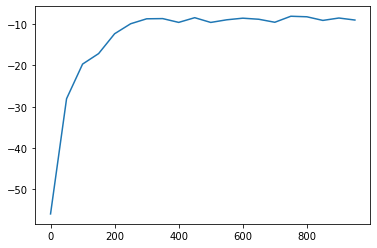

In [156]:
import matplotlib.pyplot as plt
plt.plot(xs, ys)

In [157]:
π(0, 0, θ)

0.7048156952052697